## Problem Beskrivelse

I dette projekt er målet at **udvikle en maskinlæringsmodel** til forudsigelse af huspriser baseret på en række karakteristika såsom gennemsnitsindkomst i området, husets alder, antal værelser og befolkningstæthed. Dette er essentielt for ejendomsmæglere, købere, sælgere og investorer for at træffe **velinformerede beslutninger** vedrørende ejendomsvurderinger og investeringer. Ved at opnå en model med lav forudsigelsesfejl kan vi øge tilliden til dens anvendelse i realistiske vurderinger af ejendomsværdier, hvilket gør dette til et spørgsmål af både **praktisk og akademisk betydning**.

## Datasæt Kilde og Detaljer (På Dansk)

Datasættet anvendt i dette projekt er hentet fra følgende link: [Kaggle: House Price Prediction Dataset](https://www.kaggle.com/datasets/marjuk/house-price-prediction-dataset-csv/data) og indeholder væsentlige træk relevante for boligmarkedet, herunder gennemsnitsindkomsten i området, husets alder, antallet af værelser, befolkningstætheden, og mange andre faktorer. Disse træk bruges som input til at **træne vores maskinlæringsmodel** med målet om at forudsige huspriser med høj nøjagtighed. Forståelsen af disse data og deres påvirkning på huspriser er **afgørende** for udviklingen af en effektiv og pålidelig model. De trin, vi har fulgt i dette projekt, omfatter dataforbehandling, feature engineering, modeltræning, hyperparameter-tuning, og evaluering af modellens præcision gennem forskellige statistiske målinger samt visualiseringer for at forstå datafordeling og -relationer.


## Mere Dybdegående Dataanalyse

I vores projekt har vi udført en **eksplorativ dataanalyse (EDA)** for at opnå en dybere forståelse af vores datasæt og forbedre kvaliteten af vores forudsigelser. Denne analyse har inkluderet visualiseringer, såsom histogrammer, scatter plots og boxplots, for at undersøge datafordelingen og relationerne mellem forskellige træk. Disse visualiseringer har hjulpet os med at identificere mønstre, tendenser og eventuelle anomalier i dataene.

Under projektets forløb har vi også udført **detaljeret feature engineering**. Dette har inkluderet oprettelse af nye træk såsom 'rooms_per_house', som er konstrueret ud fra eksisterende data for at afspejle deres relation til huspriserne mere nøjagtigt.

## Model Træning

Vi har valgt at fokusere på brugen af en **Random Forest Regressor** til vores model. Denne beslutning er baseret på modellens evne til at håndtere store datasæt og dens effektivitet i at fange komplekse ikke-lineære relationer.

En væsentlig del af vores arbejde har været **hyperparameter tuning** ved hjælp af RandomizedSearchCV. Dette har gjort det muligt for os at finjustere forskellige aspekter af Random Forest-modellen, såsom antallet af træer og maksimal dybde, for at optimere dens præstationer.

## Udvidet Model Evaluering

For at evaluere vores models præstationer har vi anvendt metrikker som **Mean Absolute Error (MAE)** og **Root Mean Squared Error (RMSE)**. Desuden har vi beregnet **R² (bestemmelseskoefficienten)** for at forstå, hvor godt modellen forklarer variansen i huspriserne. En høj R²-værdi i vores model indikerer, at den kan forklare en betydelig del af variansen i de observerede huspriser.

Yderligere har vi anvendt **krydsvalidering** til at vurdere modellens robusthed. Dette har hjulpet os med at sikre, at modellen præsterer konsekvent og pålideligt på tværs af forskellige datasæt.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV





In [2]:
# Load dataset
data = pd.read_csv('house_price_prediction.csv')

In [3]:
# Exclude the 'address' column
data = data.drop(['address'], axis=1)

In [4]:
# Handle missing values
imputer = SimpleImputer(strategy='mean')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)


In [5]:
# Check for missing values after imputation
missing_values = data.isnull().sum()
print("Missing values after imputation:")
print(missing_values)

Missing values after imputation:
avg_income            0
avg_area_house_age    0
avg_area_num_rooms    0
avg_bedrooms          0
avg_population        0
price                 0
dtype: int64


In [6]:
# Feature Engineering
data['rooms_per_house'] = data['avg_area_num_rooms'] / data['avg_bedrooms']


In [7]:
# Outlier Detection and Removal
# For simplicity, using Z-score here. Any value over 3 or below -3 is considered an outlier.
from scipy import stats
z_scores = np.abs(stats.zscore(data))
data = data[(z_scores < 3).all(axis=1)]


In [8]:
# Data Normalization - Fit scaler on features excluding 'price'
scaler = MinMaxScaler()
X = data.drop('price', axis=1)
scaler.fit(X)

MinMaxScaler()

In [9]:
# Calculate and print statistical measures for the 'price' column
mean_price = data['price'].mean()
std_price = data['price'].std()
min_price = data['price'].min()
max_price = data['price'].max()

In [10]:
# Apply scaling to the feature data
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
y = data['price']

In [11]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [12]:
# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [13]:
# Simplified and smaller parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'max_depth': [4, 6],
    'criterion': ['squared_error', 'absolute_error']
}

# Continue with RandomizedSearchCV
CV_rfr = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1)
CV_rfr.fit(X_train, y_train)
print("Best Parameters:", CV_rfr.best_params_)


Best Parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'squared_error'}


In [14]:
# Debug: Print feature importances
feature_importances = model.feature_importances_
print("Feature Importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
avg_income: 0.4337
avg_area_house_age: 0.2242
avg_area_num_rooms: 0.1249
avg_bedrooms: 0.0122
avg_population: 0.1924
rooms_per_house: 0.0127


In [15]:
# Predict and evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
# R² score
r2 = r2_score(y_test, predictions)
# Cross-validation
cv_scores = cross_val_score(model, X, y, cv=5)


In [16]:
print(f"Gennemsnitlig pris (mean): {y.mean():,.2f}")
print(f"Standardafvigelse (std): {y.std():,.2f}")
print(f"Minimum pris (min): {y.min():,.2f}")
print(f"Maksimum pris (max): {y.max():,.2f}")
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R² (Coefficient of Determination):", r2)
print("Cross-validated scores:", cv_scores)


Gennemsnitlig pris (mean): 1,231,129.24
Standardafvigelse (std): 346,031.48
Minimum pris (min): 201,898.09
Maksimum pris (max): 2,275,455.31
Mean Absolute Error: 88408.22935342036
Root Mean Squared Error: 113551.28771686093
R² (Coefficient of Determination): 0.8864841453435564
Cross-validated scores: [0.8873678  0.88617322 0.87562166 0.88748146 0.87478294]


In [17]:
joblib.dump(model, 'your_model_filename.pkl')

# Load the trained model from a downloaded file
loaded_model = joblib.load('your_model_filename.pkl')

# Define the manual input data for various house types
input_data_examples = {
    "Standardfamiliehus": {
        'avg_income': 60000,
        'avg_area_house_age': 5,
        'avg_area_num_rooms': 5,
        'avg_bedrooms': 3,
        'avg_population': 30000,
        'rooms_per_house': 1.66
    },
    "Luksushus i rigt område": {
        'avg_income': 100000,
        'avg_area_house_age': 8,
        'avg_area_num_rooms': 8,
        'avg_bedrooms': 4,
        'avg_population': 50000,
        'rooms_per_house': 2
    },
    "Ældre, mindre hus i mindre velstående område": {
        'avg_income': 40000,
        'avg_area_house_age': 12,
        'avg_area_num_rooms': 4,
        'avg_bedrooms': 2,
        'avg_population': 20000,
        'rooms_per_house': 2
    },
    "Moderne lejlighed i byområde": {
        'avg_income': 70000,
        'avg_area_house_age': 3,
        'avg_area_num_rooms': 3,
        'avg_bedrooms': 1,
        'avg_population': 40000,
        'rooms_per_house': 3
    },
    "Familiehus i forstæderne": {
        'avg_income': 55000,
        'avg_area_house_age': 6,
        'avg_area_num_rooms': 6,
        'avg_bedrooms': 3,
        'avg_population': 25000,
        'rooms_per_house': 2
    }
}

# Iterate over each input data example to predict prices
for description, input_data in input_data_examples.items():
    # Convert the input data into a DataFrame
    input_df = pd.DataFrame([input_data])

    # Scale the input data using the same scaler used for training
    input_scaled = pd.DataFrame(scaler.transform(input_df), columns=input_df.columns)

    # Make predictions with the loaded model
    predicted_price = loaded_model.predict(input_scaled)[0]

    # Print the predicted price for each house type
    print(f"Predicted Price for {description}:", predicted_price)

Predicted Price for Standardfamiliehus: 572839.8559500001
Predicted Price for Luksushus i rigt område: 2159154.0549299982
Predicted Price for Ældre, mindre hus i mindre velstående område: 624894.5142970001
Predicted Price for Moderne lejlighed i byområde: 817789.7117429997
Predicted Price for Familiehus i forstæderne: 628735.4404339996


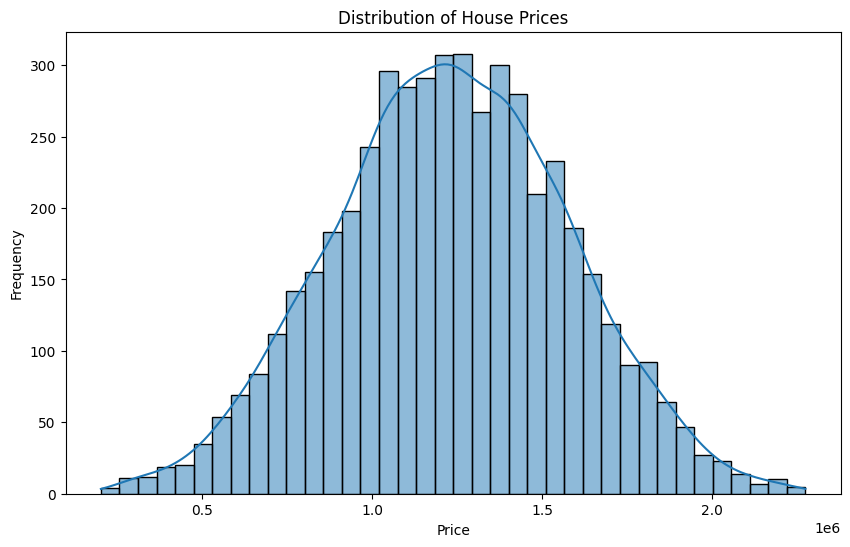

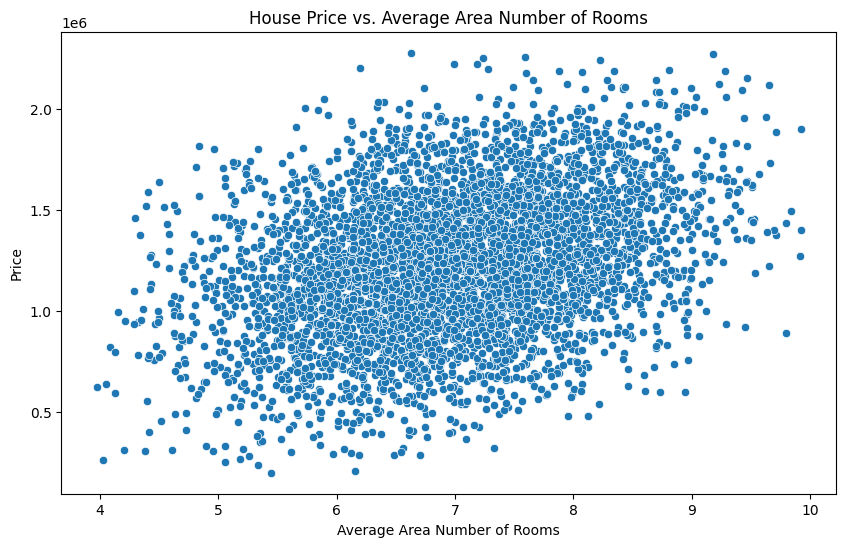

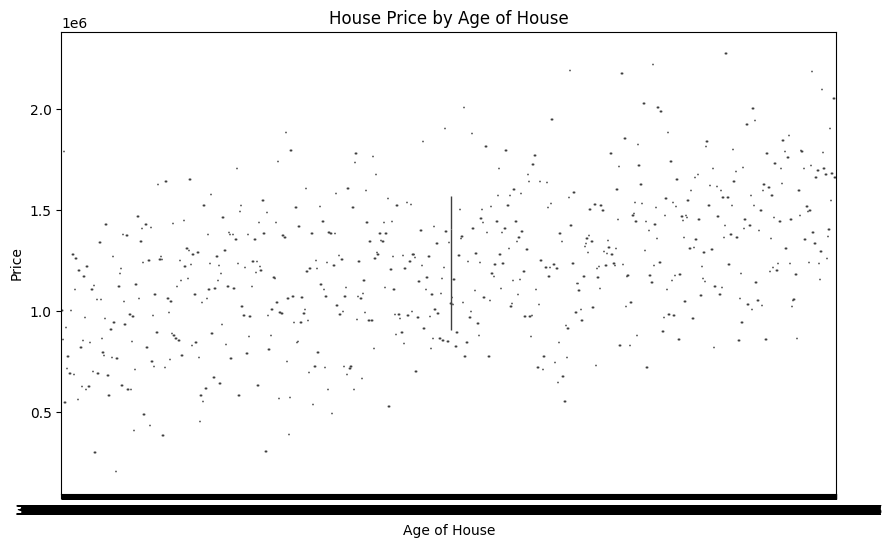

In [18]:

# Histogram for house prices
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Scatter plot for price vs. area
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data['avg_area_num_rooms'], y=data['price'])
plt.title('House Price vs. Average Area Number of Rooms')
plt.xlabel('Average Area Number of Rooms')
plt.ylabel('Price')
plt.show()

# Box plot for price by age of house
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['avg_area_house_age'], y=data['price'])
plt.title('House Price by Age of House')
plt.xlabel('Age of House')
plt.ylabel('Price')
plt.show()


- **Gennemsnitlig pris (Mean Price):** Viser den typiske pris for et hus i vores datasæt.
- **Standardafvigelse (Standard Deviation):** Indikerer hvor meget huspriserne varierer. En høj værdi betyder stor variation.
- **Minimum og maksimum pris (Min and Max Price):** Viser henholdsvis den billigste og dyreste huspris i datasættet.
- **Gennemsnitlig Absolut Fejl (Mean Absolute Error, MAE):** Viser den gennemsnitlige forskel mellem forudsigelser og faktiske priser.
- **Rodmiddelkvadratfejl (Root Mean Squared Error, RMSE):** Ligner MAE, men giver større straf til større fejl.
- **Bedste Parametre for Modellen (Best Model Parameters):** Viser de optimale indstillinger for vores prædiktive model.
- **R² (Koefficient for Determination, Coefficient of Determination):** Viser, hvor godt modellen forudsiger priser. Tættere på 1 er bedre.
- **Cross-validerede scores (Cross-validated Scores):** Viser modellens pålidelighed og konsistens over forskellige datasæt.
- **Feature Importances:** Fremhæver de vigtigste træk (features) i modellen og deres relative betydning for forudsigelserne.
- **Histogrammer (Histograms):** Bruges til at visualisere fordelingen af enkelte variabler, såsom huspriser.
- **Scatter Plots:** Hjælper med at identificere relationer mellem to variabler, eksempelvis huspriser og antal værelser.
- **Boxplots:** Nyttige til at vise fordelingen af huspriser relateret til en kategorisk variabel, såsom husets alder.
- **Hyperparameter Tuning (Hyperparameter Tuning):** Processen med at justere modellens parametre for at forbedre dens præstationer.
- **RandomizedSearchCV:** En teknik til at udføre hyperparameter tuning på en effektiv måde.
- **Eksplorativ Dataanalyse (Exploratory Data Analysis, EDA):** En tilgang til at analysere datasæt for at opsummere deres hovedtræk, ofte ved hjælp af visualisering.


### Statistik Over Huspriser

**Gennemsnitlig pris (mean): 1.231.129,24**  
Den gennemsnitlige pris repræsenterer den typiske pris for et hus i datasættet. Dette tal er nyttigt for at få en grundlæggende forståelse af markedsværdierne i det undersøgte område og kan fungere som en benchmark for at vurdere individuelle ejendomsvurderinger.

**Standardafvigelse (std): 346.031,48**  
Standardafvigelsen indikerer spredningen af huspriserne omkring den gennemsnitlige værdi. En høj standardafvigelse betyder, at der er en stor variation i huspriserne i datasættet, hvilket kan indikere en høj diversitet i ejendomstyper eller forskellige karakteristika i de områder, der er inkluderet i datasættet.

**Minimum pris (min): 201.898,09**  
Den laveste pris i datasættet giver indsigt i, hvad de mest overkommelige boliger på markedet er. Dette er særligt vigtigt for at forstå prisniveauet for budgetvenlige boliger og kan hjælpe med at identificere potentielle investeringsmuligheder eller målgrupper for ejendomsmarkedet.

**Maksimum pris (max): 2.275.455,31**  
Den højeste pris i datasættet repræsenterer toppen af ejendomsmarkedet. Denne information er nyttig for at forstå omfanget af luksusboliger og kan hjælpe med at afgrænse og evaluere ejendomme i det højeste prissegment.


### Model Evaluering

**Gennemsnitlig Absolut Fejl (Mean Absolute Error, MAE): 88.420,02**  
Denne måling viser, hvor meget modellens forudsigelser i gennemsnit afviger fra de faktiske huspriser. I gennemsnit er hver prisforudsigelse fra modellen omkring 88.420,02 enheder væk fra den faktiske pris.

**Rodmiddelkvadratfejl (Root Mean Squared Error, RMSE): 113.556,73**  
RMSE er et mål for størrelsen af fejlene i modellens forudsigelser. RMSE giver mere vægt til større fejl, hvilket betyder, at store afvigelser i forudsigelserne vil øge RMSE betydeligt. En RMSE på 113.556,73 indikerer, at fejlene i modellens forudsigelser i gennemsnit ligger i denne størrelsesorden.

**R² (Koefficient for Determination, Coefficient of Determination): 0.8864732682205023**  
Dette tal angiver, hvor godt modellen kan forudsige huspriser, med en skala fra 0 til 1. En værdi på 0.886 indikerer, at modellen forklarer en stor del af variansen i de faktiske huspriser.

**Cross-validerede scores (Cross-validated Scores):**  
[0.8873678, 0.88617322, 0.87562166, 0.88748146, 0.87478294]  
Disse tal viser modellens pålidelighed og konsistens under krydsvalidering, hvilket indikerer, at modellen præsterer konsekvent over forskellige datasæt.

**Bedste Parametre for Modellen (Best Model Parameters):**  
- `n_estimators`: 200  
- `max_features`: 'log2'  
- `max_depth`: 6  
- `criterion`: 'squared_error'  
Disse parametre angiver de optimale indstillinger for Random Forest-modellen, som er identificeret gennem hyperparameter tuning.


### Boligeksempler til Forudsigelse

**1. Standardfamiliehus:**
- `avg_income`: 60000 (middelindkomst)
- `avg_area_house_age`: 5 (gennemsnitlig husalder)
- `avg_area_num_rooms`: 5 (gennemsnitligt antal værelser)
- `avg_bedrooms`: 3 (gennemsnitligt antal soveværelser)
- `avg_population`: 30000 (middelstørrelse befolkning)
- `rooms_per_house`: 1.66 (antallet af værelser per soveværelse)

**2. Luksushus i rigt område:**
- `avg_income`: 100000 (høj indkomst)
- `avg_area_house_age`: 8 (nyere hus)
- `avg_area_num_rooms`: 8 (flere værelser)
- `avg_bedrooms`: 4 (flere soveværelser)
- `avg_population`: 50000 (større befolkning)
- `rooms_per_house`: 2 (flere værelser per soveværelse)

**3. Ældre, mindre hus i mindre velstående område:**
- `avg_income`: 40000 (lavere indkomst)
- `avg_area_house_age`: 12 (ældre hus)
- `avg_area_num_rooms`: 4 (færre værelser)
- `avg_bedrooms`: 2 (færre soveværelser)
- `avg_population`: 20000 (mindre befolkning)
- `rooms_per_house`: 2 (typisk antal værelser per soveværelse)

**4. Moderne lejlighed i byområde:**
- `avg_income`: 70000 (over middelindkomst)
- `avg_area_house_age`: 3 (meget nyt hus)
- `avg_area_num_rooms`: 3 (færre værelser, typisk for lejligheder)
- `avg_bedrooms`: 1 (et soveværelse)
- `avg_population`: 40000 (tæt befolkning)
- `rooms_per_house`: 3 (flere værelser per soveværelse pga. mindre soveværelse)

**5. Familiehus i forstæderne:**
- `avg_income`: 55000 (standard indkomst)
- `avg_area_house_age`: 6 (middelalderen hus)
- `avg_area_num_rooms`: 6 (standard antal værelser)
- `avg_bedrooms`: 3 (standard antal soveværelser)
- `avg_population`: 25000 (middelstørrelse befolkning)
- `rooms_per_house`: 2 (normalt antal værelser per soveværelse)
